In [1]:
import numpy as np
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from data import JSRTDataModule

In [2]:
#from enn_unet import ENN_UNet

In [111]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from pytorch_lightning import LightningModule
from torchmetrics.functional import dice#, iou, hausdorff_distance

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)
    
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()

        self.downsample = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            nn.MaxPool2d(2)            
        )

    def forward(self, x):
        return self.downsample(x)

class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x, y):

        # x is from last layer y is skip connection
        x = self.upsample(x)
        diffY = y.size()[2] - x.size()[2]
        diffX = y.size()[3] - x.size()[3]

        x = F.pad(x, (diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2))
        x = torch.cat([y, x], dim=1)
        x = self.conv(x)

        return x
    
class EndConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EndConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):
        # use softplus to avoid negative values
        # this resents evidence over classes
        return F.softplus(self.conv(x))
    
# from https://github.com/clabrugere/evidential-deeplearning/blob/main/model/loss.py
class SSBayesRiskLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        """Same as CEBayesRiskLoss but here the cost function is the sum of squares instead."""
        super().__init__(*args, **kwargs)

    def forward(self, evidences, betas, labels):
    
        # the loss expects the target to be one-hot encoded
        eye = torch.eye(len(np.unique(labels.cpu().numpy())), dtype=torch.float32, device=evidences.device)
        labels = eye[labels].permute(0, 3, 1, 2)

        alphas = evidences + 1.0
        strength = torch.sum(alphas, dim=1, keepdim=True)
        probabilities = alphas / strength

        error = (labels - probabilities) ** 2
        variance = probabilities * (1.0 - probabilities) / (strength + 1.0)

        loss = torch.sum(error + variance, dim=-1)

        return torch.mean(loss)

class KLDivergenceLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        """Acts as a regularization term to shrink towards zero the evidence of samples that cannot be correctly classified"""
        super().__init__(*args, **kwargs)

    def forward(self, evidences, labels):
        eye = torch.eye(len(np.unique(labels.cpu().numpy())), dtype=torch.float32, device=evidences.device)
        labels = eye[labels].permute(0, 3, 1, 2)

        num_classes = evidences.size(-1)
        alphas = evidences + 1.0
        alphas_tilde = labels + (1.0 - labels) * alphas
        strength_tilde = torch.sum(alphas_tilde, dim=-1, keepdim=True)

        # lgamma is the log of the gamma function
        first_term = (
            torch.lgamma(strength_tilde)
            - torch.lgamma(evidences.new_tensor(num_classes, dtype=torch.float32))
            - torch.sum(torch.lgamma(alphas_tilde), dim=-1, keepdim=True)
        )
        second_term = torch.sum(
            (alphas_tilde - 1.0) * (torch.digamma(alphas_tilde) - torch.digamma(strength_tilde)), dim=-1, keepdim=True
        )
        loss = torch.mean(first_term + second_term)

        return loss

class ENN_UNet(LightningModule):
    def __init__(self, output_dim: int, learning_rate: float = 0.001, loss = SSBayesRiskLoss(), kl = KLDivergenceLoss()):
        super().__init__()
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.test_probmaps = []
        self.test_predmaps = []
        self.loss = loss
        self.kl = kl

        self.conv_block_start = ConvBlock(1, 32)
        self.down_block_1 = Downsample(32, 64)
        self.down_block_2 = Downsample(64, 128)
        self.down_block_3 = Downsample(128, 256)
        self.up_block_1 = Upsample(256, 128)
        self.up_block_2 = Upsample(128, 64)
        self.up_block_3 = Upsample(64, 16)
        self.conv_block_end = EndConvBlock(16, self.output_dim * 2)


    def forward(self, x):

        x1 = self.conv_block_start(x)
        x2 = self.down_block_1(x1)
        x3 = self.down_block_2(x2)
        x4 = self.down_block_3(x3)
        x5 = self.up_block_1(x4, x3)
        x6 = self.up_block_2(x5, x2)
        x7 = self.up_block_3(x6, x1)
        x_out = self.conv_block_end(x7)

        evidences, betas = torch.chunk(x_out, 2, dim=1)
        # increase each evidence tensor by 1 to avoid negative values
        alphas = evidences + torch.ones_like(evidences)
        strength = torch.sum(alphas, dim=1, keepdim=True)
        probabilities = alphas / strength

        return evidences, betas, probabilities

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def process_batch(self, batch):
        x, y = batch['image'], batch['labelmap']
        logits, betas, probs = self(x)
        loss = self.loss(logits, betas, y.squeeze()) + 0.2*self.kl(logits, y.squeeze())

        preds = torch.argmax(probs, dim=1)
        dsc = dice(preds, y.squeeze(), average='macro', num_classes=self.output_dim, ignore_index=0)

        return loss, dsc, probs, preds

    def training_step(self, batch, batch_idx):
        loss, dsc, probs, preds = self.process_batch(batch)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_dice", dsc, prog_bar=True)

        if batch_idx == 0:
            grid = torchvision.utils.make_grid(batch['image'][0:4, ...], nrow=2, normalize=True)
            self.logger.experiment.add_image('train_images', grid, self.global_step)

            grid = torchvision.utils.make_grid(batch['labelmap'][0:4, ...].type('torch.FloatTensor'), nrow=2, normalize=True)
            self.logger.experiment.add_image('train_labelmaps', grid, self.global_step)

            max_probs = torch.max(probs, dim=1, keepdim=True)[0]
            grid = torchvision.utils.make_grid(max_probs[0:4, ...], nrow=2, normalize=False)
            self.logger.experiment.add_image('train_probmaps', grid, self.global_step)

            grid = torchvision.utils.make_grid(preds[0:4, ...].unsqueeze(1).type('torch.FloatTensor'), nrow=2, normalize=True)
            self.logger.experiment.add_image('train_predmaps', grid, self.global_step)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, dsc, _, _ = self.process_batch(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_dice", dsc, prog_bar=True)

    def on_test_start(self):
        self.test_probmaps = []
        self.test_predmaps = []

    def test_step(self, batch, batch_idx):
        loss, dsc, probs, preds = self.process_batch(batch)
        self.log("test_loss", loss)
        self.log("test_dice", dsc)
        self.test_probmaps.append(probs)
        self.test_predmaps.append(preds)

In [112]:
seed_everything(42, workers=True)

data = JSRTDataModule(data_dir='./data/JSRT/', batch_size=16)

model = ENN_UNet(output_dim=4, learning_rate=0.001)
#model = ViTSegmenter(output_dim=4, learning_rate=0.001)

trainer = Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=[0],
    log_every_n_steps=10,
    logger=TensorBoardLogger(save_dir='./lightning_logs/segmentation/', name='jsrt-conv-unet'),
    callbacks=[ModelCheckpoint(monitor="val_loss", mode='min'), TQDMProgressBar(refresh_rate=10)],
)
trainer.fit(model=model, datamodule=data)

trainer.validate(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

trainer.test(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

Seed set to 42


True



Loading Data: 100%|██████████| 187/187 [00:00<00:00, 64043.02it/s]

Loading Data: 100%|██████████| 10/10 [00:00<00:00, 40960.00it/s]

Loading Data: 100%|██████████| 50/50 [00:00<00:00, 65352.20it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | loss             | SSBayesRiskLoss  | 0     
1 | kl               | KLDivergenceLoss | 0     
2 | conv_block_start | ConvBlock        | 9.7 K 
3 | down_block_1     | Downsample       | 55.7 K
4 | down_block_2     | Downsample       | 221 K 
5 | down_block_3     | Downsample       | 886 K 
6 | up_block_1       | Upsample         | 574 K 
7 | up_block_2       | Upsample         | 143 K 
8 | up_block_3       | Upsample         | 19.8 K
9 | conv_block_end   | EndConvBlock     | 1.2 K 
-----------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at ./lightning_logs/segmentation/jsrt-conv-unet/version_108/checkpoints/epoch=48-step=588.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./lightning_logs/segmentation/jsrt-conv-unet/version_108/checkpoints/epoch=48-step=588.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_dice             0.971326470375061
        val_loss             4.086852073669434
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Restoring states from the checkpoint path at ./lightning_logs/segmentation/jsrt-conv-unet/version_108/checkpoints/epoch=48-step=588.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./lightning_logs/segmentation/jsrt-conv-unet/version_108/checkpoints/epoch=48-step=588.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_dice            0.961809515953064
        test_loss            5.005553245544434
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 5.005553245544434, 'test_dice': 0.961809515953064}]

Text(0.5, 1.0, 'probability map')

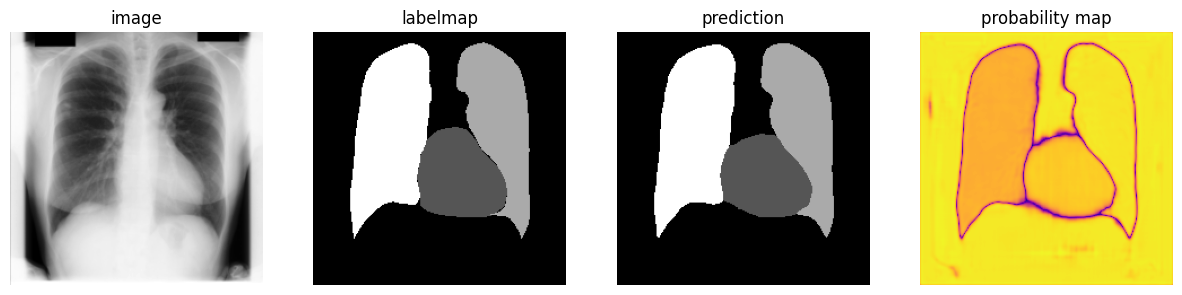

In [116]:
import matplotlib.pyplot as plt
import matplotlib
#from matplotlib.cm import ScalarMappable
image_num = 0
test_sample = data.test_set[image_num]
image = test_sample['image'].squeeze()
labelmap = test_sample['labelmap'].squeeze()
probmap = torch.max(model.test_probmaps[0].cpu(), dim=1, keepdim=True)[0].squeeze().detach().numpy()
predmap = model.test_predmaps[0][image_num,...].cpu().numpy()

f, ax = plt.subplots(1,4, figsize=(15, 15))

ax[0].imshow(image, cmap=matplotlib.cm.gray)
ax[0].axis('off')
ax[0].set_title('image')

ax[1].imshow(labelmap, cmap=matplotlib.cm.gray)
ax[1].axis('off')
ax[1].set_title('labelmap')

ax[2].imshow(predmap, cmap=matplotlib.cm.gray)
ax[2].axis('off')
ax[2].set_title('prediction')

ax[3].imshow(probmap[image_num, ...], cmap='plasma')
ax[3].axis('off')
ax[3].set_title('probability map')

# sm = ScalarMappable(cmap=matplotlib.cm.bwr)
# sm.set_array([])
# cbar = f.colorbar(sm, ax=ax[3], orientation='vertical', pad=0.02)
# cbar.set_label('Concentration')

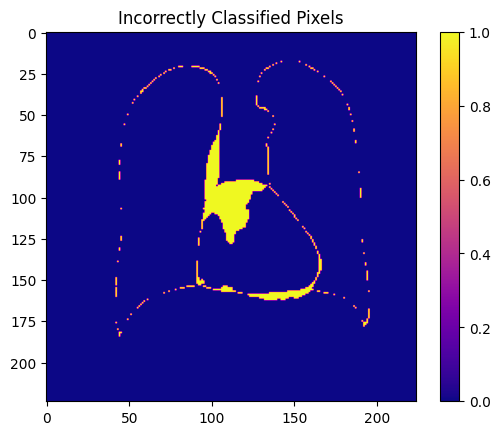

In [115]:
# tensor with 0 if labelmap and predmap match and 1 otherwise
# this shows 
diff_info = labelmap - predmap#torch.abs(labelmap - predmap)
# 1 if not 0 and 0 otherwise
# this just shows differences
diff = torch.where(diff_info == 0, torch.zeros_like(diff_info), torch.ones_like(diff_info))
plt.imshow(diff.detach().numpy(), cmap='plasma');
plt.colorbar();
plt.title('Incorrectly Classified Pixels');

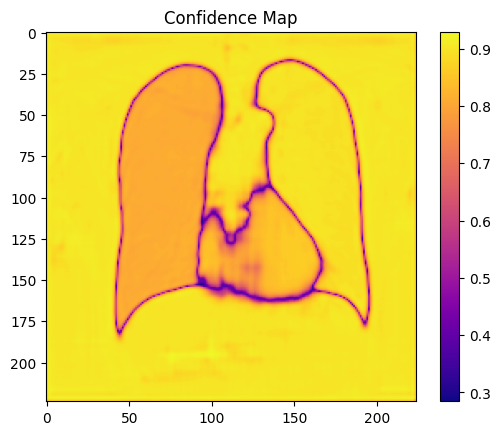

In [114]:
probmap = torch.max(model.test_probmaps[0].cpu(), dim=1, keepdim=True)[0]
# plot the probability map with colourbar
plt.imshow(probmap[image_num, ...].squeeze().detach().numpy(), cmap='plasma');
plt.colorbar();
plt.title('Confidence Map');

In [87]:
pprobmap = model.test_probmaps[0].cpu()
print((pprobmap.sum(dim=1)-1).max())

tensor(2.3842e-07)
